In [7]:
import sys
import os
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np


C:\Users\adequ\AppData\Local\Temp\ipykernel_32048\2533064962.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [26]:
# Parameters
current_directory = os.getcwd()

# Name of the model to be evaluated
model_name = 'AgeRecognitionModel.keras'

# Name of the directory in which files with test results will be saved
evaluation_directory_name = 'eval-test'

# Name of the file with the data for each image
eval_file_name = 'evaluation.txt'

# Path to the folder containing images to be used for testing purposes
images_path = 'D:\\repos\Python\images'

# Parameter defining whether model predicted age accurately - absolute value of difference between labelled age and predicted age
accuracy_param = 7

# Parameter defining whether the accuracy should be checked in relation to the percentage difference or difference between labelled age and predicted age
accuracy_in_percentage = False

# Size of the age group, ex. for age_group_size = 10, the age groups will be [0-9, 10-19, ...] 
age_group_size = 10

In [17]:
# Load the pre-trained model
model_path = os.path.join(current_directory, model_name)
model = load_model(model_path)

In [16]:
# Defining used functions

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory at path: {path}")
    else:
        print("Directory already exists, clearing content...")
        # Clear the contents of the directory
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")

def write_to_text_file(dir_path, file_name, content):
    file_path = os.path.join(dir_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'a') as file:
            file.write(content + '\n')
    else:
        with open(file_path, 'w') as file:
            file.write(content + '\n')

def get_image_features(image_path):
    img = image.load_img(image_path, grayscale=True)
    img = img.resize((128, 128), Image.LANCZOS)
    img = image.img_to_array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

# specific logic for data from: https://www.kaggle.com/datasets/rashikrahmanpritom/age-recognition-dataset
# or other images that contains labelled age in the format: AGE_x_y_z.jpg (age must be in the first index separated by '_' sign)
def eval_dataset(image_file, dir_path, model, eval_dir, accuracy_param):
    img = get_image_features(os.path.join(dir_path, image_file))

    predictions = model.predict(img)
    age = round(predictions[0][0])

    splitted_text = image_file.split('_')
    labelled_age = int(splitted_text[0])
    difference = abs(labelled_age - age);
    percent_difference = abs(int(difference)) / labelled_age * 100
    is_accurate = round(percent_difference) <= accuracy_param if accuracy_in_percentage else round(difference) <= accuracy_param

    eval_file_name = 'evaluation.txt'
    obj = {
        'Model': age,
        'Label': labelled_age,
        'Difference': difference,
        'PercentageDifference': round(percent_difference),
        'Accurate': is_accurate
    }
    write_to_text_file(eval_dir, eval_file_name, str(obj))

def test_images(directory_path, model, eval_dir, accuracy_param):
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print(f"The specified path '{directory_path}' is not a valid directory.")
        return
    
    files = os.listdir(directory_path)
    
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No image files found in '{directory_path}'.")
        return
    
    for image_file in image_files:
        try:
            eval_dataset(image_file, directory_path, model, eval_dir, accuracy_param)
        except Exception as e:
            print(f"Error processing {image_file}. Reason: {e}")

In [32]:
def analyze_and_visualize_data(eval_dir, file_path):
    data_file = os.path.join(eval_dir, file_path)
    if not os.path.exists(data_file):
        print(f'There is no such a file at the path: {data_file}')
        
    with open(data_file, 'r') as file:
        lines = file.readlines()

    data_str = ''.join(lines).replace('\n', ',')

    data_list = eval('[' + data_str + ']')

    df = pd.DataFrame(data_list)

    # Calculate RMSE and MAPE for all data in the dataset
    rmse_all = np.sqrt(mean_squared_error(df['Label'], df['Model']))
    mape_all = np.mean(np.abs((df['Model'] - df['Label']) / df['Label'])) * 100

    print("RMSE for all data:", rmse_all)
    print("MAPE for all data:", mape_all)

    age_ranges = list(range(0, 111, age_group_size))
    age_labels = [f"{start}-{start+age_group_size-1}" for start in age_ranges[:-1]]

    df['AgeGroup'] = pd.cut(df['Label'], bins=age_ranges, labels=age_labels, right=False)

    rmse_groups = []
    mape_groups = []

    for age_group in age_labels:
        group = df[df['AgeGroup'] == age_group]

        if group.empty:
            rmse_groups.append(0)
            mape_groups.append(0)
            continue

        rmse_group = np.sqrt(mean_squared_error(group['Label'], group['Model']))
        mape_group = np.mean(np.abs((group['Model'] - group['Label']) / group['Label'])) * 100
        rmse_groups.append(rmse_group)
        mape_groups.append(mape_group)
        print(f"\nRMSE for age group {age_group}:", rmse_group)
        print(f"MAPE for age group {age_group}:", mape_group)

    correct_predictions = df[df['Accurate'] == True].shape[0]
    total_predictions = df.shape[0]
    accuracy = correct_predictions / total_predictions * 100

    print("\nAccuracy:", accuracy, "%")

    results_dict = {
        'RMSE_all': rmse_all,
        'MAPE_all': mape_all,
        'RMSE_groups': rmse_groups,
        'MAPE_groups': mape_groups,
        'Accuracy': accuracy
    }

    result_file_path = os.path.join(eval_dir, 'result.txt')
    with open(result_file_path, 'w') as results_file:
        results_file.write(str(results_dict))

    labels = [str(age_group) for age_group in age_labels]

    plt.figure(figsize=(16, 6))

    # RMSE plot for age groups
    plt.subplot(2, 2, 1)
    plt.bar(labels, rmse_groups, color='blue')
    plt.title('RMSE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('RMSE')

    # MAPE plot for age groups
    plt.subplot(2, 2, 2)
    plt.bar(labels, mape_groups, color='orange')
    plt.title('MAPE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('MAPE')

    # Accuracy pie plot
    plt.subplot(2, 2, 3)
    plt.pie([correct_predictions, total_predictions - correct_predictions], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title('Accuracy of Predictions')

    plt.tight_layout()
    plt.show()

In [27]:

# Create directory or remove its content to save data
evaluation_directory_path = os.path.join(current_directory, evaluation_directory_name)
create_directory(evaluation_directory_path)
# Evaluate test images using provided model 
test_images(images_path, model, evaluation_directory_path, accuracy_param)

Directory already exists, clearing content...
1/1 [==============================] - 0s 124ms/step


d:\repos\Python\AgeRecognition\my_env\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


RMSE for all data: 9.89295237835857
MAPE for all data: 24.50420573662253

RMSE for age group 0-9: 8.331902595348142
MAPE for age group 0-9: 80.39603061062289

RMSE for age group 10-19: 7.137906280868441
MAPE for age group 10-19: 38.99204418741822

RMSE for age group 20-29: 5.135014813814005
MAPE for age group 20-29: 14.58001439294147

RMSE for age group 30-39: 5.349560827499807
MAPE for age group 30-39: 14.223385689354275

RMSE for age group 40-49: 9.47484875131628
MAPE for age group 40-49: 17.191142237621772

RMSE for age group 60-69: 12.744810601518909
MAPE for age group 60-69: 15.74522340538757

RMSE for age group 70-79: 14.752366993222415
MAPE for age group 70-79: 15.626019179938066

RMSE for age group 80-89: 16.68023257422266
MAPE for age group 80-89: 15.784682940258696

RMSE for age group 90-99: 20.547772081177072
MAPE for age group 90-99: 17.74344506384969

Accuracy: 65.39518522589864 %


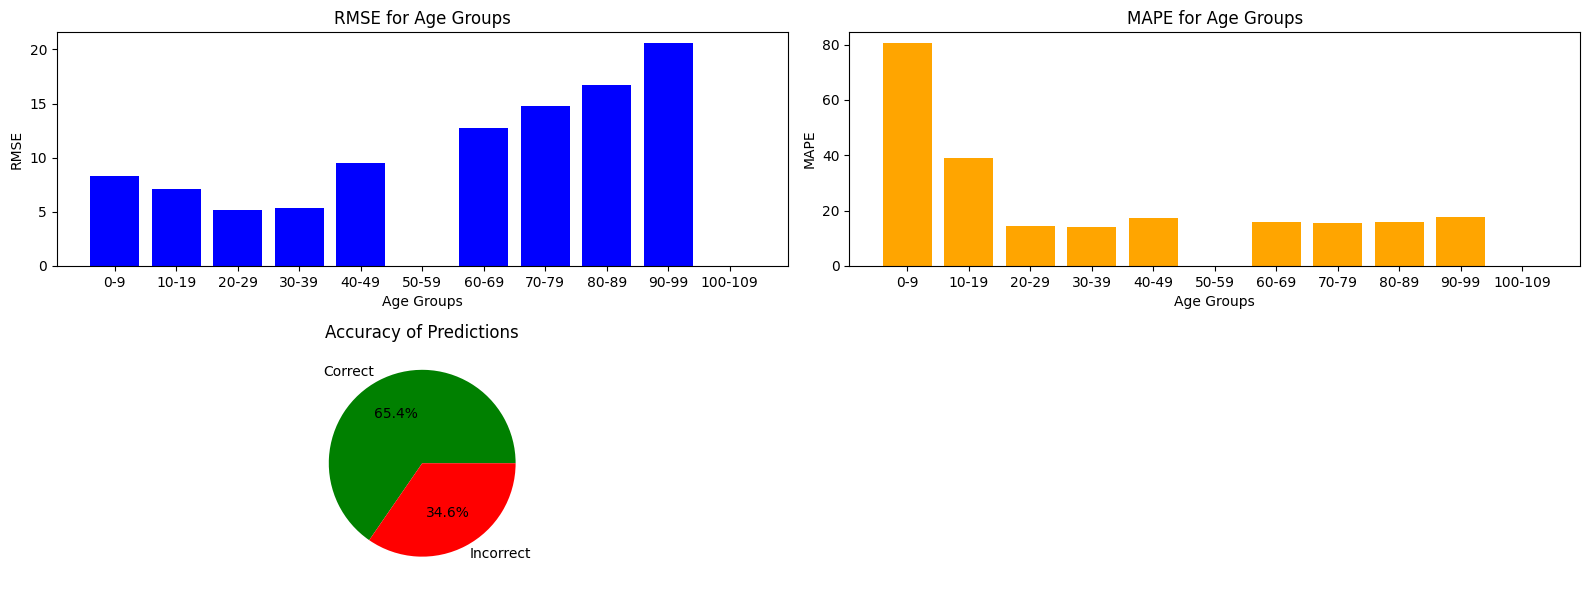

In [33]:
# Analyze and visualize data from the file located at evaluation_directory_path/eval_file_name
analyze_and_visualize_data(evaluation_directory_path, eval_file_name)